In [16]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [17]:
train_raw = pd.read_csv("data/train.csv")


First we will split our training data into 'train' and 'eval'. This allows us to have a holdout set to benchmark ourselves as we develop our solution.
Here we chose to hold out 20% of our training data for eval purposes

In [18]:
train_raw = train_raw.drop(columns=['SNo'])
train, eval = train_test_split(train_raw.sort_values(by='time'), train_size=0.8, shuffle=False)
print(train.shape)
print(train['Label'].value_counts())
print(eval.shape)
print(eval['Label'].value_counts())

(35808, 20)
Label
0    28360
2     6123
1     1325
Name: count, dtype: int64
(8952, 20)
Label
0    6819
2    1633
1     500
Name: count, dtype: int64


In [19]:
import pandas as pd
import numpy as np
from scipy import stats
from imblearn.combine import SMOTETomek, SMOTEENN

    
def data_preprocessing_1(df, sampling_technique=None):

    feature_names = [x for x in df.columns if x != 'Label']

    print(f'Labels before subsampling')
    print(df['Label'].value_counts())

    if sampling_technique == 'remove_dups':
        sampled_df = df.groupby(feature_names, as_index=False).agg({'Label': lambda x:stats.mode(x)[0]}).copy().reset_index(drop=True)
        X_df = sampled_df[feature_names]
        y_df = sampled_df['Label']

    elif sampling_technique == 'SMOTE-TOMEK':
        smo_tek = SMOTETomek(random_state=0)
        X_df, y_df = smo_tek.fit_resample(df.drop(columns=['Label']), df['Label'])

    elif sampling_technique == 'SMOTE-ENN':
        smo_een = SMOTEENN(random_state=0)
        X_df, y_df = smo_een.fit_resample(df.drop(columns=['Label']), df['Label'])
    else:
        print('invalid/no sampling technique specified')
        X_df = df[feature_names]
        y_df = df['Label']
    
    print(f'Labels after subsampling')
    print(y_df.value_counts())


    return X_df, y_df

In [20]:
print('-----BASELINE-----')
X_baseline, y_baseline = data_preprocessing_1(train, sampling_technique=None)
print('\n-----NO DUPLICATES-----')
X_nodups, y_nodups = data_preprocessing_1(train, sampling_technique='remove_dups')
print('\n-----SMOTE-TOMEK-----')
X_smo_tomek, y_smo_tomek = data_preprocessing_1(train, sampling_technique='SMOTE-TOMEK')
print('\n-----SMOTE-ENN-----')
X_smo_enn, y_smo_enn = data_preprocessing_1(train, sampling_technique='SMOTE-ENN')

y_eval = eval['Label']
X_eval = eval.drop(columns=['Label'])


-----BASELINE-----
Labels before subsampling
Label
0    28360
2     6123
1     1325
Name: count, dtype: int64
invalid/no sampling technique specified
Labels after subsampling
Label
0    28360
2     6123
1     1325
Name: count, dtype: int64

-----NO DUPLICATES-----
Labels before subsampling
Label
0    28360
2     6123
1     1325
Name: count, dtype: int64
Labels after subsampling
Label
0    12718
2     2091
1      479
Name: count, dtype: int64

-----SMOTE-TOMEK-----
Labels before subsampling
Label
0    28360
2     6123
1     1325
Name: count, dtype: int64
Labels after subsampling
Label
0    28345
1    28317
2    28316
Name: count, dtype: int64

-----SMOTE-ENN-----
Labels before subsampling
Label
0    28360
2     6123
1     1325
Name: count, dtype: int64
Labels after subsampling
Label
0    24275
1    22987
2    18936
Name: count, dtype: int64


In [21]:
from sklearn.metrics import classification_report

In [22]:
from xgboost import XGBClassifier

print('-----BASELINE-----')
xgb_baseline = XGBClassifier()
xgb_baseline.fit(X_baseline, y_baseline)
xgb_baseline_preds = xgb_baseline.predict(X_eval)
print(classification_report(y_eval, xgb_baseline_preds, digits=4)) 

-----BASELINE-----


              precision    recall  f1-score   support

           0     0.8249    0.8692    0.8465      6819
           1     0.5893    0.3760    0.4591       500
           2     0.4613    0.4091    0.4336      1633

    accuracy                         0.7577      8952
   macro avg     0.6252    0.5514    0.5797      8952
weighted avg     0.7454    0.7577    0.7495      8952



In [23]:
print('-----NO DUPLICATES-----')
xgb_nodups = XGBClassifier()
xgb_nodups.fit(X_nodups, y_nodups)
xgb_nodups_preds = xgb_nodups.predict(X_eval)
print(classification_report(y_eval, xgb_nodups_preds, digits=4)) 

-----NO DUPLICATES-----
              precision    recall  f1-score   support

           0     0.8279    0.9010    0.8629      6819
           1     0.5452    0.4700    0.5048       500
           2     0.5373    0.3619    0.4325      1633

    accuracy                         0.7786      8952
   macro avg     0.6368    0.5776    0.6001      8952
weighted avg     0.7591    0.7786    0.7644      8952



In [24]:
print('-----SMOTE-TOMEK-----')
xgb_smo_tomek = XGBClassifier()
xgb_smo_tomek.fit(X_smo_tomek, y_smo_tomek)
xgb_smo_tomek_preds = xgb_smo_tomek.predict(X_eval)
print(classification_report(y_eval, xgb_smo_tomek_preds, digits=4)) 

-----SMOTE-TOMEK-----


              precision    recall  f1-score   support

           0     0.8238    0.8619    0.8424      6819
           1     0.4879    0.3620    0.4156       500
           2     0.4616    0.4091    0.4338      1633

    accuracy                         0.7513      8952
   macro avg     0.5911    0.5443    0.5639      8952
weighted avg     0.7390    0.7513    0.7440      8952



In [25]:
print('-----SMOTE-ENN-----')
xgb_smo_enn = XGBClassifier()
xgb_smo_enn.fit(X_smo_enn, y_smo_enn)
xgb_smo_enn_preds = xgb_smo_enn.predict(X_eval)
print(classification_report(y_eval, xgb_smo_enn_preds, digits=4)) 

-----SMOTE-ENN-----


              precision    recall  f1-score   support

           0     0.8387    0.8557    0.8471      6819
           1     0.5047    0.4300    0.4644       500
           2     0.4895    0.4703    0.4797      1633

    accuracy                         0.7616      8952
   macro avg     0.6110    0.5853    0.5971      8952
weighted avg     0.7564    0.7616    0.7587      8952



It seems that the duplicate removal data prep is best for our particular dataset. We will use this data from this point forward

<!-- Because SMOTE creates synthetic training samples based on the given dataset, it is not appropriate to use for k-folding without some modification in order to ensure that synthetic examples are not used to evaluate the model -->

In [27]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)

accuracies = []
f1_macros = []
f1_weighted = []


for train_idx, test_idx, in cv.split(X_baseline, y_baseline):
    X_train, X_test = X_baseline.iloc[train_idx], X_baseline.iloc[test_idx]
    y_train, y_test = y_baseline.iloc[train_idx], y_baseline.iloc[test_idx]
    # X_train, y_train = SMOTEENN(random_state=0).fit_resample(X_train, y_train)
    model = XGBClassifier()
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    accuracies.append(model.score(X_test, y_test))
    f1_macros.append(f1_score(y_test, y_pred, average="macro"))     
    f1_weighted.append(f1_score(y_test, y_pred, average="weighted"))        

print(f'Accuracy: {accuracies}')
print(f'Mean: {np.mean(accuracies)}')
print(f'F-score macro: {f1_macros}')
print(f'Mean: {np.mean(f1_macros)}')
print(f'F-score weighted: {f1_weighted}')
print(f'Mean: {np.mean(f1_weighted)}')

Accuracy: [0.6135157777157219, 0.656660150795867, 0.7922368053616309, 0.7880184331797235, 0.7845273006563329]
Mean: 0.7269916935418552
F-score macro: [0.4822316670246429, 0.5105879967678238, 0.5322200925131368, 0.6374296698513221, 0.45389788873950004]
Mean: 0.5232734629792851
F-score weighted: [0.6460151515905849, 0.6850807811306017, 0.7603842626553591, 0.7926805520286536, 0.7184123367537526]
Mean: 0.7205146168317904


# Feature Importance

Next we will take a look at feature importance to see if we can create a more generalizable model by dropping the least important features

In [12]:
importances = pd.DataFrame({
    'Feature': X_smo_enn.columns,
    'Importance': xgb_smo_enn.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
PSL,0.471056
lat,0.158747
Z1000,0.053003
TMQ,0.037275
U850,0.035241
month,0.024951
year,0.023366
Z200,0.021958
V850,0.019102


<Axes: xlabel='Feature'>

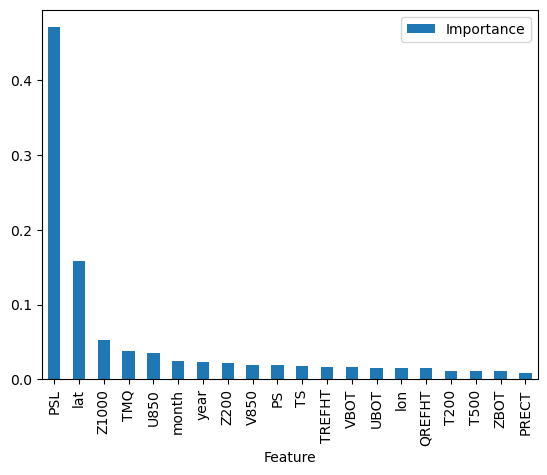

In [13]:
importances.plot.bar()

We seem to have quite a few columns with very low importance. We will try dropping some and see if this improves performance

In [21]:
print('-----SMOTE-ENN - Dropping 2 least important features -----')
features_to_drop_2 = ['T500', 'PRECT']
xgb_smo_enn_2_feat_drop = XGBClassifier()
xgb_smo_enn_2_feat_drop.fit(X_smo_enn.drop(columns=features_to_drop_2), y_smo_enn)
xgb_smo_enn_2_feat_drop_preds = xgb_smo_enn_2_feat_drop.predict(X_eval.drop(columns=features_to_drop_2))
print(classification_report(y_eval, xgb_smo_enn_2_feat_drop_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_2_feat_drop_preds)}')

-----SMOTE-ENN - Dropping 2 least important features -----
              precision    recall  f1-score   support

           0     0.9788    0.8714    0.9220      7036
           1     0.6437    0.9452    0.7658       365
           2     0.6566    0.9110    0.7632      1551

    accuracy                         0.8813      8952
   macro avg     0.7597    0.9092    0.8170      8952
weighted avg     0.9093    0.8813    0.8881      8952

Accuracy: 0.8812555853440572


In [22]:
print('-----SMOTE-ENN - Dropping 4 least important features -----')
features_to_drop_4 = ['T200', 'ZBOT', 'T500', 'PRECT']
xgb_smo_enn_4_feat_drop = XGBClassifier()
xgb_smo_enn_4_feat_drop.fit(X_smo_enn.drop(columns=features_to_drop_4), y_smo_enn)
xgb_smo_enn_4_feat_drop_preds = xgb_smo_enn_4_feat_drop.predict(X_eval.drop(columns=features_to_drop_4))
print(classification_report(y_eval, xgb_smo_enn_4_feat_drop_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_4_feat_drop_preds)}')

-----SMOTE-ENN - Dropping 4 least important features -----
              precision    recall  f1-score   support

           0     0.9766    0.8729    0.9219      7036
           1     0.6460    0.9397    0.7656       365
           2     0.6576    0.9039    0.7613      1551

    accuracy                         0.8810      8952
   macro avg     0.7601    0.9055    0.8163      8952
weighted avg     0.9079    0.8810    0.8877      8952

Accuracy: 0.8810321715817694


In [23]:
print('-----SMOTE-ENN - Dropping 6 least important features from old run -----')
features_to_drop_6 = ['PS', 'V850', 'T200', 'ZBOT', 'T500', 'PRECT']
xgb_smo_enn_6_feat_drop = XGBClassifier()
xgb_smo_enn_6_feat_drop.fit(X_smo_enn.drop(columns=features_to_drop_6), y_smo_enn)
xgb_smo_enn_6_feat_drop_preds = xgb_smo_enn_6_feat_drop.predict(X_eval.drop(columns=features_to_drop_6))
print(classification_report(y_eval, xgb_smo_enn_6_feat_drop_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_6_feat_drop_preds)}')

-----SMOTE-ENN - Dropping 6 least important features from old run -----
              precision    recall  f1-score   support

           0     0.9785    0.8731    0.9228      7036
           1     0.6450    0.9507    0.7685       365
           2     0.6601    0.9091    0.7648      1551

    accuracy                         0.8825      8952
   macro avg     0.7612    0.9110    0.8187      8952
weighted avg     0.9097    0.8825    0.8891      8952

Accuracy: 0.8824843610366399


In [24]:
print('-----SMOTE-ENN - Dropping 8 least important features -----')
features_to_drop_8 = ['UBOT', 'VBOT', 'PS', 'V850', 'T200', 'ZBOT', 'T500', 'PRECT']
xgb_smo_enn_8_feat_drop = XGBClassifier()
xgb_smo_enn_8_feat_drop.fit(X_smo_enn.drop(columns=features_to_drop_8), y_smo_enn)
xgb_smo_enn_8_feat_drop_preds = xgb_smo_enn_8_feat_drop.predict(X_eval.drop(columns=features_to_drop_8))
print(classification_report(y_eval, xgb_smo_enn_8_feat_drop_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_8_feat_drop_preds)}')

-----SMOTE-ENN - Dropping 8 least important features -----
              precision    recall  f1-score   support

           0     0.9763    0.8721    0.9213      7036
           1     0.6453    0.9370    0.7642       365
           2     0.6551    0.9026    0.7592      1551

    accuracy                         0.8800      8952
   macro avg     0.7589    0.9039    0.8149      8952
weighted avg     0.9072    0.8800    0.8868      8952

Accuracy: 0.8800268096514745


In [25]:
print('-----SMOTE-ENN - Dropping 10 least important features -----')
features_to_drop_10 = ['lon', 'TS', 'UBOT', 'VBOT', 'PS', 'V850', 'T200', 'ZBOT', 'T500', 'PRECT']
xgb_smo_enn_10_feat_drop = XGBClassifier()
xgb_smo_enn_10_feat_drop.fit(X_smo_enn.drop(columns=features_to_drop_10), y_smo_enn)
xgb_smo_enn_10_feat_drop_preds = xgb_smo_enn_10_feat_drop.predict(X_eval.drop(columns=features_to_drop_10))
print(classification_report(y_eval, xgb_smo_enn_10_feat_drop_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_10_feat_drop_preds)}')

-----SMOTE-ENN - Dropping 10 least important features -----
              precision    recall  f1-score   support

           0     0.9806    0.8640    0.9186      7036
           1     0.6360    0.9479    0.7613       365
           2     0.6455    0.9194    0.7585      1551

    accuracy                         0.8770      8952
   macro avg     0.7541    0.9104    0.8128      8952
weighted avg     0.9085    0.8770    0.8845      8952

Accuracy: 0.8770107238605898


In [26]:
print('-----SMOTE-ENN - Dropping 12 least important features -----')
features_to_drop_12 = ['TREFHT', 'QREFHT', 'lon', 'TS', 'UBOT', 'VBOT', 'PS', 'V850', 'T200', 'ZBOT', 'T500', 'PRECT']
xgb_smo_enn_12_feat_drop = XGBClassifier()
xgb_smo_enn_12_feat_drop.fit(X_smo_enn.drop(columns=features_to_drop_12), y_smo_enn)
xgb_smo_enn_12_feat_drop_preds = xgb_smo_enn_12_feat_drop.predict(X_eval.drop(columns=features_to_drop_12))
print(classification_report(y_eval, xgb_smo_enn_12_feat_drop_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_12_feat_drop_preds)}')

-----SMOTE-ENN - Dropping 12 least important features -----
              precision    recall  f1-score   support

           0     0.9795    0.8630    0.9176      7036
           1     0.6382    0.9425    0.7611       365
           2     0.6409    0.9149    0.7538      1551

    accuracy                         0.8752      8952
   macro avg     0.7529    0.9068    0.8108      8952
weighted avg     0.9069    0.8752    0.8828      8952

Accuracy: 0.8752234137622877


In [27]:
print('-----SMOTE-ENN - Dropping 13 least important features -----')
features_to_drop_13 = ['Z200', 'TREFHT', 'QREFHT', 'lon', 'TS', 'UBOT', 'VBOT', 'PS', 'V850', 'T200', 'ZBOT', 'T500', 'PRECT']
xgb_smo_enn_13_feat_drop = XGBClassifier()
xgb_smo_enn_13_feat_drop.fit(X_smo_enn.drop(columns=features_to_drop_13), y_smo_enn)
xgb_smo_enn_13_feat_drop_preds = xgb_smo_enn_13_feat_drop.predict(X_eval.drop(columns=features_to_drop_13))
print(classification_report(y_eval, xgb_smo_enn_13_feat_drop_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_13_feat_drop_preds)}')

-----SMOTE-ENN - Dropping 13 least important features -----
              precision    recall  f1-score   support

           0     0.9783    0.8640    0.9176      7036
           1     0.6357    0.9370    0.7575       365
           2     0.6432    0.9123    0.7545      1551

    accuracy                         0.8753      8952
   macro avg     0.7524    0.9044    0.8098      8952
weighted avg     0.9062    0.8753    0.8828      8952

Accuracy: 0.8753351206434317


In [28]:
print('-----SMOTE-ENN - Dropping 14 least important features -----')
features_to_drop_14 = ['month', 'Z200', 'TREFHT', 'QREFHT', 'lon', 'TS', 'UBOT', 'VBOT', 'PS', 'V850', 'T200', 'ZBOT', 'T500', 'PRECT']
xgb_smo_enn_14_feat_drop = XGBClassifier()
xgb_smo_enn_14_feat_drop.fit(X_smo_enn.drop(columns=features_to_drop_14), y_smo_enn)
xgb_smo_enn_14_feat_drop_preds = xgb_smo_enn_14_feat_drop.predict(X_eval.drop(columns=features_to_drop_14))
print(classification_report(y_eval, xgb_smo_enn_14_feat_drop_preds, digits=4)) 
print(f'Accuracy: {accuracy_score(y_eval, xgb_smo_enn_14_feat_drop_preds)}')

-----SMOTE-ENN - Dropping 14 least important features -----
              precision    recall  f1-score   support

           0     0.9715    0.8610    0.9129      7036
           1     0.6195    0.9233    0.7415       365
           2     0.6340    0.8878    0.7397      1551

    accuracy                         0.8682      8952
   macro avg     0.7416    0.8907    0.7980      8952
weighted avg     0.8986    0.8682    0.8759      8952

Accuracy: 0.8681858802502234


In [29]:
preds = {
    0: xgb_smo_enn_preds,
    2: xgb_smo_enn_2_feat_drop_preds,
    4: xgb_smo_enn_4_feat_drop_preds,
    6: xgb_smo_enn_6_feat_drop_preds,
    8: xgb_smo_enn_8_feat_drop_preds, 
    10: xgb_smo_enn_10_feat_drop_preds,
    12: xgb_smo_enn_12_feat_drop_preds,
    13: xgb_smo_enn_13_feat_drop_preds,
    14: xgb_smo_enn_14_feat_drop_preds,
}

accuracies = [accuracy_score(y_eval, x) for x in preds.values()]
f1_macro = [f1_score(y_eval, x, average='macro') for x in preds.values()]
f1_weighted = [f1_score(y_eval, x, average='weighted') for x in preds.values()]

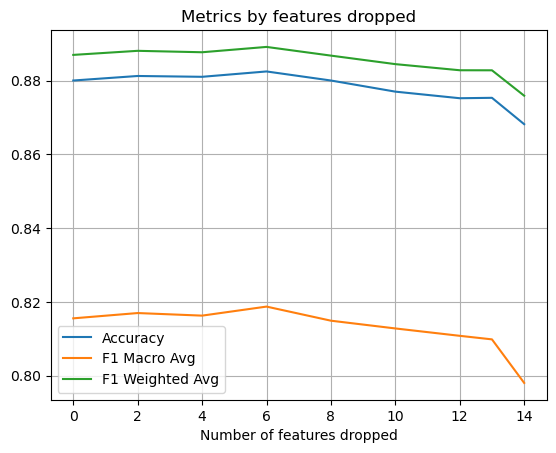

In [30]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(preds.keys(), accuracies, label='Accuracy')
plt.plot(preds.keys(), f1_macro, label='F1 Macro Avg')
plt.plot(preds.keys(), f1_weighted, label='F1 Weighted Avg')
plt.legend()
plt.title('Metrics by features dropped')
plt.xlabel('Number of features dropped')
plt.grid()
plt.show()


We could argue that any choice between 4-8 features dropped may be appropriate, as dropping these features does not have a large impact on performance but would result in a less complex model.
Beyond 12 features dropped we see a sharp drop in performance, we will not want to go any further than this

We choose to go with 6 features dropped

In [73]:
features_to_drop =  ['PS', 'V850', 'T200', 'ZBOT', 'T500', 'PRECT']
X_train_dropped_feats = X_baseline.drop(columns=features_to_drop)
X_eval_dropped_feats = X_eval.drop(columns=features_to_drop)

In [63]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ("SMOTE-ENN", SMOTEENN(random_state=10)),
    ("XGBClassifier", XGBClassifier(random_state=10, 
                                    verbosity=1,
                                    eval_set=[X_eval_dropped_feats, y_eval]))
])
parameters = {
    # "XGBClassifier__n_estimators": [350],
    # "XGBClassifier__learning_rate": [0.1],
    # Grid Search 1
    "XGBClassifier__max_depth": [12],
    "XGBClassifier__min_child_weight": [9],
    # Grid Search 2
    'XGBClassifier__gamma':[0.0],
    # Grid Search 3
    'XGBClassifier__subsample':[0.75],
    'XGBClassifier__colsample_bytree':[0.6],
    # Grid Search 4
    'XGBClassifier__reg_alpha':[0],
    # Grid Search 5
    'XGBClassifier__reg_lambda':[1],
    # Grid Search 6
    "XGBClassifier__learning_rate": [0.1],
    "XGBClassifier__n_estimators": [350],
    }

clf = GridSearchCV(pipeline, 
                   param_grid=parameters,
                   verbose=1, 
                   cv=5, 
                   n_jobs=-1)

clf.fit(X_train_dropped_feats, y_baseline)

print(clf.best_params_)
print(clf.best_score_)

best_model = clf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:28:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set" } are not used.

{'XGBClassifier__colsample_bytree': 0.6, 'XGBClassifier__gamma': 0.0, 'XGBClassifier__learning_rate': 0.1, 'XGBClassifier__max_depth': 12, 'XGBClassifier__min_child_weight': 9, 'XGBClassifier__n_estimators': 350, 'XGBClassifier__reg_alpha': 0, 'XGBClassifier__reg_lambda': 1, 'XGBClassifier__subsample': 0.75}
0.8731288709308906


In [74]:
print(classification_report(y_eval, best_model.predict(X_eval_dropped_feats), digits=4))

ValueError: Feature shape mismatch, expected: 12, got 14

# Predict on Test

Train model on all training data using our best hyperparameters

In [75]:
test = pd.read_csv("data/test.csv")

test = test.drop(columns=['SNo'])
test = time_split(test)
test = test.drop(columns=features_to_drop)

test

,lat,lon,TMQ,U850,UBOT,VBOT,QREFHT,PSL,TS,TREFHT,Z1000,Z200,year,month
0,-30.391134,354.3750,25.907482,6.662070,-7.432653,-3.936030,0.010624,101532.5391,290.697632,290.039947,129.814316,11948.68848,2010,10
1,-30.391134,354.3750,25.907482,6.662070,-7.432653,-3.936030,0.010624,101532.5391,290.697632,290.039947,129.814316,11948.68848,2010,10
2,-31.095176,354.3750,27.019733,4.951319,-7.286631,-3.150316,0.010890,101513.0234,290.372650,289.940613,128.204788,11931.06738,2010,10
3,-31.095176,354.3750,27.019733,4.951319,-7.286631,-3.150316,0.010890,101513.0234,290.372650,289.940613,128.204788,11931.06738,2010,10
4,-30.860495,354.3750,26.516499,5.362008,-7.257047,-2.907396,0.010821,101505.1484,290.697632,290.041351,127.552147,11936.12500,2010,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10315,24.054759,277.1875,57.411018,3.704696,-8.723821,14.131296,0.020041,100295.9375,301.174225,300.485138,66.389023,12396.92969,2010,10
10316,24.054759,276.8750,57.277252,5.944778,-8.424341,15.523009,0.020222,100210.2891,301.385193,300.541840,66.398727,12395.43750,2010,10
10317,24.054759,276.8750,57.277252,5.944778,-8.424341,15.523009,0.020222,100210.2891,301.385193,300.541840,66.398727,12395.43750,2010,10
10318,24.054759,276.5625,54.855862,8.170049,-6.791406,16.326492,0.020324,100116.5234,301.408600,300.491333,66.385506,12391.72363,2010,10


In [77]:
X_all_train = pd.concat([X_train_dropped_feats, X_eval_dropped_feats])
y_all_train = pd.concat([y_baseline, y_eval])

X_all_train, y_all_train = SMOTEENN(random_state=0).fit_resample(X_all_train, y_all_train)
# xgb_all_train = XGBClassifier(n_estimators=350, 
#                               learning_rate=0.1, 
#                               max_depth=12,
#                               min_child_weight=9,
#                               gamma=0.0,
#                               subsample=0.75,
#                               colsample_bytree=0.6)
xgb_all_train = XGBClassifier()

xgb_all_train.fit(X_all_train, y_all_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [78]:
test_preds = xgb_all_train.predict(test)

In [79]:
np.unique(test_preds, return_counts=True)

(array([0, 1, 2], dtype=int64), array([7616,  691, 2013], dtype=int64))

In [80]:
np.savetxt("data/xgboost_enn_all_train_no_tuning.csv", np.dstack((np.arange(1, test_preds.size+1),test_preds))[0],"%d,%d",header="SNo,Labels", comments='')